# Can we predict the US Dollar / Euro Exchange Rate?

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pyramid.arima import auto_arima
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

## Exchange Rate Data
Exchange rate for US Dollars to Euros from the initial use of the Euro in January 2002 through August 2018 as found at https://www.federalreserve.gov/data.htm

In [2]:
# exchange rate data
USEU_raw = pd.read_csv('USD_EU.csv', header=5)

USEU_raw.head()

,Time Period,RXI$US_N.B.EU
0,2002-01-01,ND
1,2002-01-02,0.9031
2,2002-01-03,0.8992
3,2002-01-04,0.8946
4,2002-01-07,0.8931


In [3]:
# clean data

USEU_data = USEU_raw.copy()

# convert index to datetime
USEU_data['Date'] = pd.to_datetime(USEU_raw['Time Period'])

# Convert exchange rate to a number, with coersion to throw NAs if conversion not possible
USEU_data['Rate'] = pd.to_numeric(USEU_data['RXI$US_N.B.EU'], errors='coerce')

# drop original columns
USEU_data = USEU_data.drop(columns=['Time Period', 'RXI$US_N.B.EU'])

# Remove NAs and NDs
USEU_data.dropna(inplace=True)

# reset index to sequential from 0
USEU_data.reset_index(drop=True, inplace=True)

USEU_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,4189.0,1.25222,0.141234,0.8594,1.1534,1.2684,1.3494,1.601


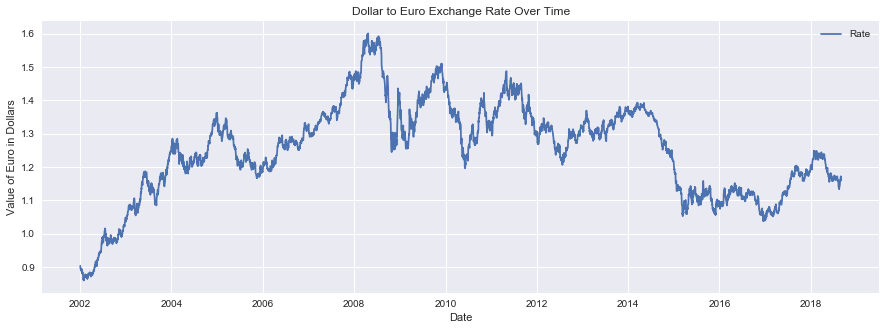

In [4]:
# plot data as time series

time_series = USEU_data.copy()
time_series.index = pd.to_datetime(time_series['Date'])
time_series = time_series.drop(columns=['Date'])

plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Rate')
plt.title('Dollar to Euro Exchange Rate Over Time')
plt.legend()
plt.show()

The euro was first put in use on January 1, 2002.  The first date with data is the second day of use.  This plot of the exhange rate over time shows that the value of the Euro started below the dollor.  The Euro value was initially at 90 cents, then dipped lower, before surpassing the Dollar by the end of the first year of use.

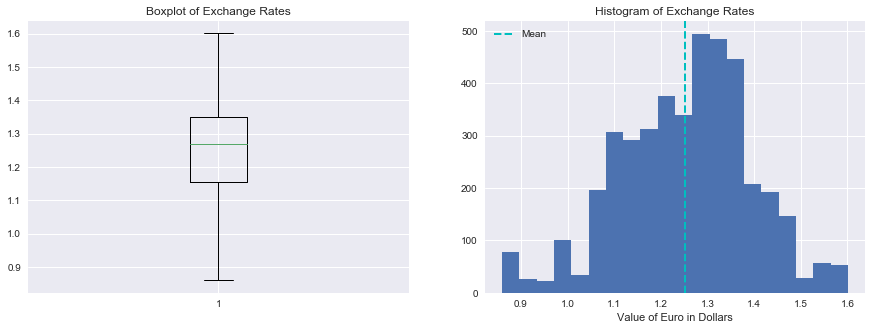

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_data.Rate)
plt.title('Boxplot of Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_data.Rate, bins=20)
plt.axvline(USEU_data.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Exchange Rates')
plt.show()

There are no notable outliers, all values fit within the whiskers of the boxplot.  The histogram shape is very close to a bell.  The data is fairly normally distributed.

Since we know from the time plot that the lowest values were in the first year, let's isolate that first year of data and take a look.

In [6]:
USEU_2002 = USEU_data.copy()

# drop data from first year of euro use
USEU_2002 = USEU_2002[USEU_2002.Date < '2003-01-01']

USEU_2002.shape

(251, 2)

In [7]:
USEU_2002.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,251.0,0.945384,0.053321,0.8594,0.88605,0.9708,0.9875,1.0485


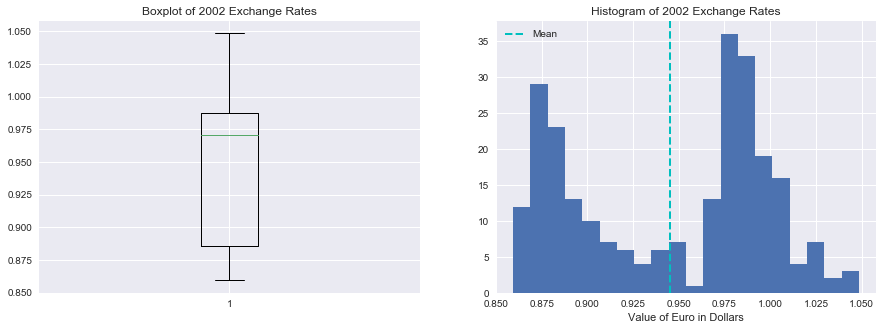

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_2002.Rate)
plt.title('Boxplot of 2002 Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_2002.Rate, bins=20)
plt.axvline(USEU_2002.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of 2002 Exchange Rates')
plt.show()

The data from 2002 contains the lowest euro values, with a mean of about 95 cents.  We'll drop the first year of data to get a more established value of the exchange rate.

In [9]:
# drop data from first year of euro use
USEU_data = USEU_data[USEU_data.Date >= '2003-01-01']

# reset index to sequential from 0
USEU_data.reset_index(drop=True, inplace=True)

USEU_data.shape

(3938, 2)

In [10]:
USEU_data.head()

,Date,Rate
0,2003-01-02,1.0361
1,2003-01-03,1.0418
2,2003-01-06,1.0469
3,2003-01-07,1.0419
4,2003-01-08,1.0447


In [11]:
USEU_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,3938.0,1.271777,0.121051,1.0361,1.178825,1.27795,1.353875,1.601


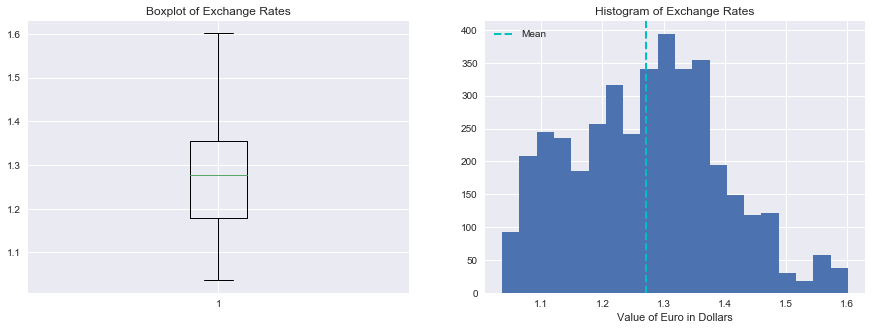

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_data.Rate)
plt.title('Boxplot of Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_data.Rate, bins=20)
plt.axvline(USEU_data.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Exchange Rates')
plt.show()

Looking at the data from 2003 forward, we see a mean of 1.27 with a range from 1.04 to 1.60 - the boxplot shows no outliers, we have normal distribution.

## Time Series Analysis
The first step in working with our data is to look at the influence of time on the exchange rate.  We will take a closer look at the data as a time series in hopes of utilizing the impact of time on our data to model and predict.

In [13]:
# set time series
time_series = USEU_data.copy()
time_series.index = pd.to_datetime(time_series['Date'])
time_series = time_series.drop(columns=['Date'])

In [14]:
time_series.head()

,Rate
Date,
2003-01-02,1.0361
2003-01-03,1.0418
2003-01-06,1.0469
2003-01-07,1.0419
2003-01-08,1.0447


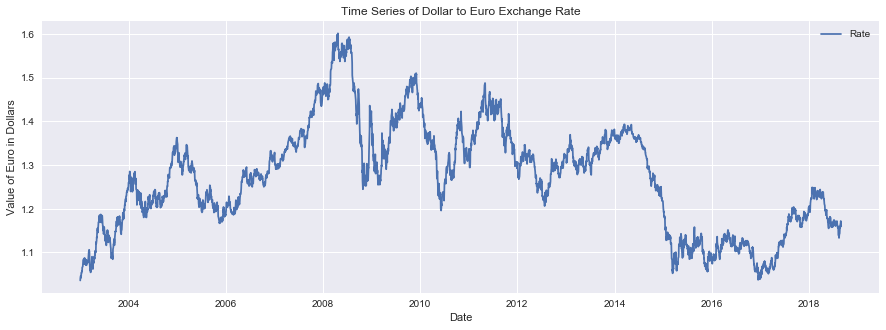

In [15]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Rate')
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

The value of the euro generally increased from 2003 through 2008.  There are then erratic rates that generally trend down through 2015.  There is a significant drop in relative value of the Euro from late 2009 to mid 2010, then again from 2014 to early 2015.

### Stationality
To further examine the data as a time series, we need to estalish stationality, which allows us isolate the variation over time.  The time-series plot makes it clear visually that our data is not stationary, in that it is not clustered around a single value.  By plotting the difference of each data point from the prior value, we should be able to see stationality.

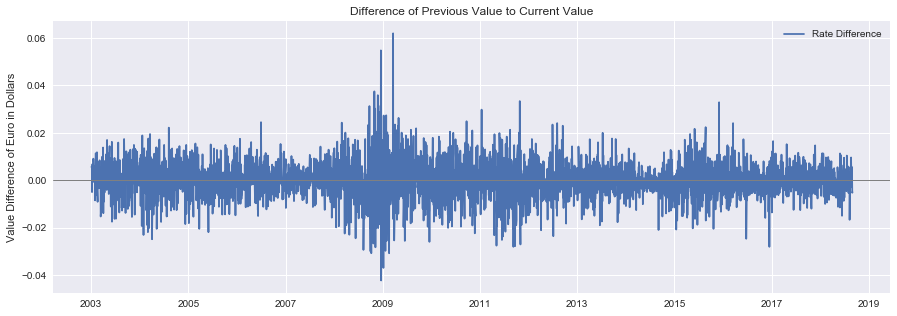

In [16]:
# difference of one record from previous
time_series['diff_1'] = time_series.Rate - time_series.Rate.shift()

plt.figure(figsize=(15, 5))
plt.plot(time_series.index, time_series.diff_1, label="Rate Difference")
plt.axhline(0, color='grey', linestyle='solid', linewidth=1)
plt.ylabel('Value Difference of Euro in Dollars')
plt.title('Difference of Previous Value to Current Value')
plt.legend()
plt.show()

This plot of difference shows the values custered around 0 - we have stationality in the data when taking a single difference.  This plot gives us insight into how our data values change from day to day.  We see greater volatility in the exchange rate in 2008 and 2009, with noticeable smaller extremes after 2009.  This reflects the economic instability of the time.  There is noticably more stability in the exchange rate in 2014 as less variation is seen from day to day.

We can mathematically test the stationality of the difference data using a Dickey Fuller test.

In [17]:
# Use statsmodel's augmented Dicky Fuller test
series = time_series.Rate
X = series.values
result = adfuller(X)
print('Exchange Rate Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Exchange Rate Dickey Fuller Test
Statistic: -2.403107
p-value: 0.140861
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [18]:
# Dicky Fuller test on the difference data
series = time_series.diff_1.dropna()
X = series.values
result = adfuller(X)
print('Exchange Rate Difference Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Exchange Rate Difference Dickey Fuller Test
Statistic: -62.348214
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


The Dickey Fuller test results show a much lower Statistic value for the differenced data, along with a much smaller p-value, indicating that the differenced data is stationary.

Now that we have some information about our time series, we'll separate out some training data and see what we can predict.

## Seasonality
Looking for recurring patterns in the data.

### Data by Year

In [27]:
season = train.copy()
season['year'], season['month'], season['day'] = season['Date'].dt.year, season['Date'].dt.month, season['Date'].dt.day

In [28]:
season.head()

,Date,Rate,year,month,day
0,2003-01-02,1.0361,2003,1,2
1,2003-01-03,1.0418,2003,1,3
2,2003-01-06,1.0469,2003,1,6
3,2003-01-07,1.0419,2003,1,7
4,2003-01-08,1.0447,2003,1,8


In [29]:
season_series = season.copy()
season_series.index = pd.to_datetime(season_series['Date'])
season_series = season_series.drop(columns=['Date'])
season_series.head()

,Rate,year,month,day
Date,,,,
2003-01-02,1.0361,2003,1,2
2003-01-03,1.0418,2003,1,3
2003-01-06,1.0469,2003,1,6
2003-01-07,1.0419,2003,1,7
2003-01-08,1.0447,2003,1,8


In [30]:
season_series.groupby('year').describe()

Rate                                                                   \
      count      mean       std     min       25%      50%       75%     max   
year                                                                           
2003  251.0  1.132057  0.050493  1.0361  1.086550  1.13370  1.169500  1.2597   
2004  253.0  1.243817  0.043363  1.1801  1.211800  1.23060  1.268500  1.3625   
2005  251.0  1.244871  0.050607  1.1667  1.203750  1.22880  1.293700  1.3476   
2006  251.0  1.256293  0.037770  1.1860  1.216300  1.26730  1.279850  1.3327   
2007  254.0  1.371063  0.052929  1.2904  1.335900  1.36005  1.413325  1.4862   
2008  252.0  1.472560  0.102261  1.2446  1.414775  1.48365  1.558950  1.6010   
2009  252.0  1.393547  0.072267  1.2547  1.328075  1.40375  1.457400  1.5100   
2010  250.0  1.326090  0.059157  1.1959  1.282725  1.33295  1.365950  1.4536   
2011  251.0  1.393133  0.046384  1.2926  1.360300  1.39760  1.431950  1.4875   
2012  251.0  1.285874  0.033053  1.2062  1.258350  1.29400  1.312750  1.3463   
2013  240.0  1.326080  0.025483  1.2774  1.305850  1.32600  1.346850  1.3810   

        day             ...               month                                \
      count       mean  ...    75%   max  count      mean       std  min  25%   
year                    ...                                                     
2003  251.0  15.800797  ...   23.0  31.0  251.0  6.509960  3.435535  1.0  4.0   
2004  253.0  15.786561  ...   23.0  31.0  253.0  6.541502  3.445041  1.0  4.0   
2005  251.0  15.701195  ...   23.0  31.0  251.0  6.505976  3.422713  1.0  4.0   
2006  251.0  15.820717  ...   23.0  31.0  251.0  6.509960  3.418026  1.0  4.0   
2007  254.0  15.799213  ...   23.0  31.0  254.0  6.523622  3.425871  1.0  4.0   
2008  252.0  15.781746  ...   23.0  31.0  252.0  6.492063  3.440435  1.0  4.0   
2009  252.0  15.682540  ...   23.0  31.0  252.0  6.527778  3.421752  1.0  4.0   
2010  250.0  15.596000  ...   23.0  31.0  250.0  6.520000  3.412945  1.0  4.0   
2011  251.0  15.701195  ...   23.0  31.0  251.0  6.505976  3.422713  1.0  4.0   
2012  251.0  15.892430  ...   23.5  31.0  251.0  6.486056  3.418012  1.0  4.0   
2013  240.0  15.404167  ...   23.0  31.0  240.0  6.245833  3.292248  1.0  3.0   

                       
      50%   75%   max  
year                   
2003  7.0  9.00  12.0  
2004  7.0  9.00  12.0  
2005  6.0  9.00  12.0  
2006  6.0  9.00  12.0  
2007  7.0  9.75  12.0  
2008  6.5  9.00  12.0  
2009  7.0  9.00  12.0  
2010  6.5  9.00  12.0  
2011  6.0  9.00  12.0  
2012  6.0  9.00  12.0  
2013  6.0  9.00  12.0  

[11 rows x 24 columns]

In [31]:
season_series.groupby('year').count().mean()

Rate     250.545455
month    250.545455
day      250.545455
dtype: float64

The average number of records per year is 250.

In [32]:
# http://atedstone.github.io/pandas-plot-seasons-time-series/

# calculate day of year
season_series['doy'] = season_series.index.dayofyear

# pivot data to index by day of the year
piv = pd.pivot_table(season_series, index=['doy'],columns=['year'], values=['Rate'])

In [33]:
piv.head()

Rate                                                                  \
year    2003    2004    2005    2006    2007    2008    2009    2010    2011   
doy                                                                            
2     1.0361  1.2592     NaN     NaN  1.3286  1.4738  1.3946     NaN     NaN   
3     1.0418     NaN  1.3476  1.1980  1.3169  1.4736     NaN     NaN  1.3371   
4        NaN     NaN  1.3295  1.2091  1.3094  1.4786     NaN  1.4419  1.3306   
5        NaN  1.2679  1.3292  1.2101  1.3005     NaN  1.3576  1.4402  1.3171   
6     1.0469  1.2773  1.3187  1.2148     NaN     NaN  1.3445  1.4404  1.3027   

                      
year    2012    2013  
doy                   
2        NaN  1.3195  
3     1.3061  1.3110  
4     1.2930  1.3047  
5     1.2783     NaN  
6     1.2723     NaN

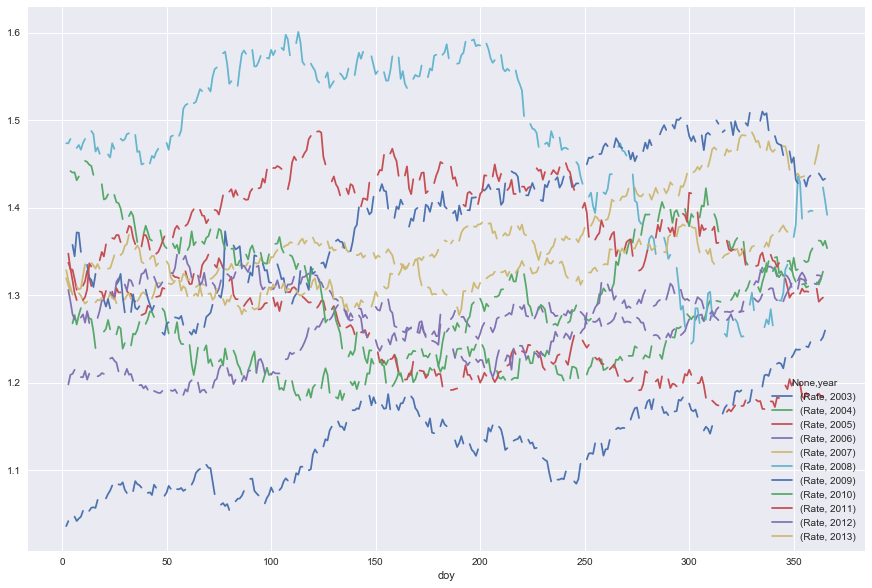

In [34]:
# plot pivot table
fig, ax = plt.subplots(figsize=(15, 10))
piv.plot(ax=ax);

By visualizing the exchange rate by each year, we see no recurring patterns to indicate seasonality.  We can test this further by decomposing the data.

### Seasonal Decomposition
Using StatsModel's Decomposition to explore trend and seasonality in the data.

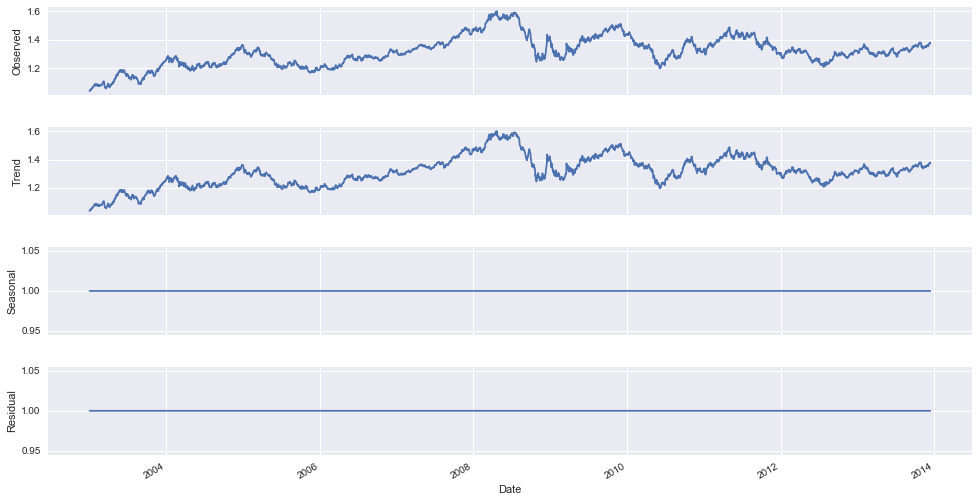

In [35]:
series = series_train.Rate

# Multiplicative decomposition using 2-day frequency

result_M1 = seasonal_decompose(series, model='multiplicative', freq=1)
fig = result_M1.plot()
fig.set_size_inches(15,8)
plt.show()

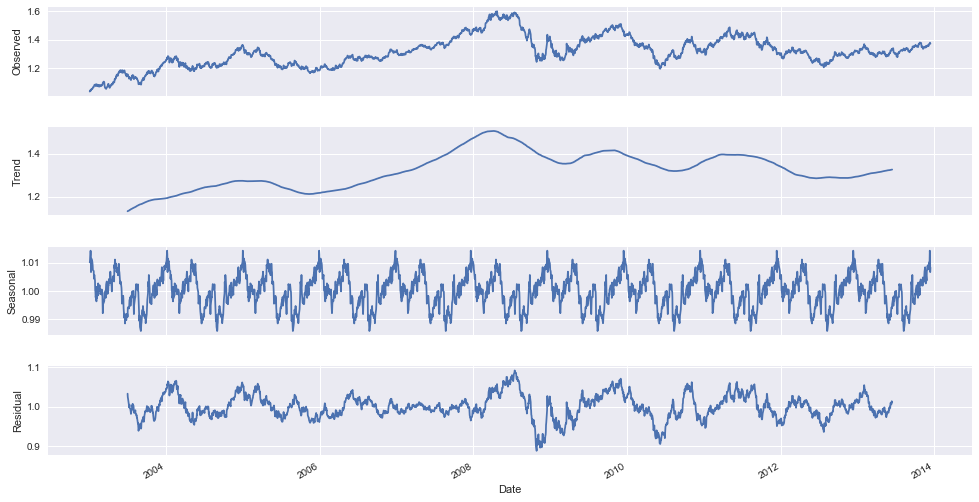

In [36]:
# Multiplicative decomposition using 250-day frequency (average yearly records)

result_M250 = seasonal_decompose(series, model='multiplicative', freq=250)
fig = result_M250.plot()
fig.set_size_inches(15,8)
plt.show()

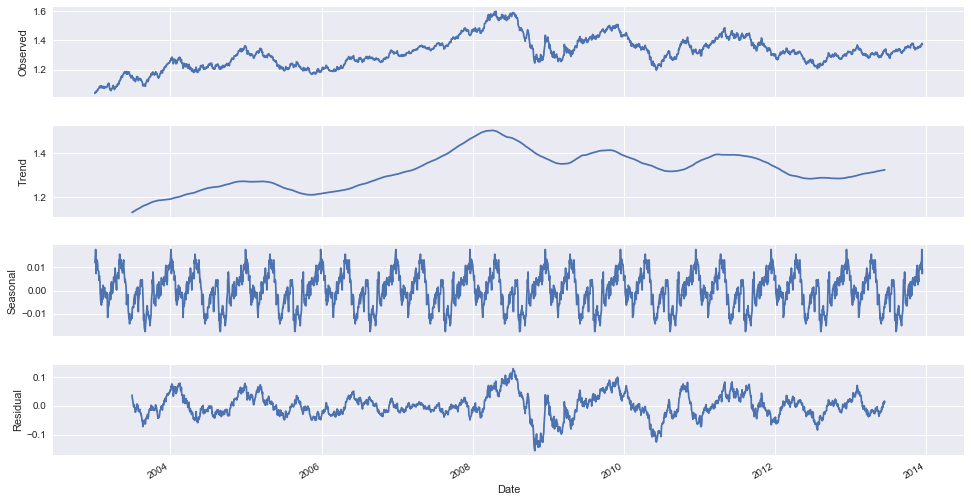

In [37]:
# Addative decomposition using 250-day frequency (average yearly records)

result_A250 = seasonal_decompose(series, model='addative', freq=250)
fig = result_A250.plot()
fig.set_size_inches(15,8)
plt.show()

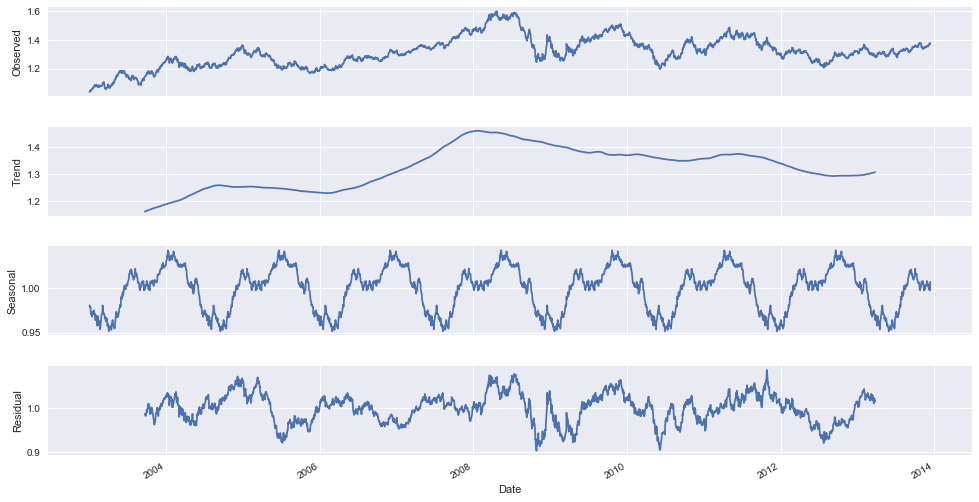

In [38]:
# Multiplicative decomposition using 1-year frequency

result_M365 = seasonal_decompose(series, model='multiplicative', freq=365)
fig = result_M365.plot()
fig.set_size_inches(15,8)
plt.show()

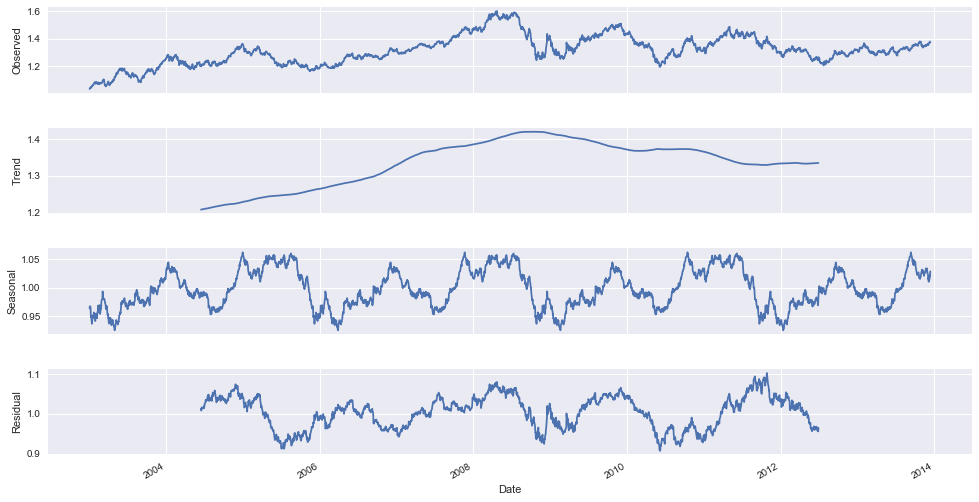

In [39]:
# Multiplicative decomposition using 2-year frequency

result_M730 = seasonal_decompose(series, model='multiplicative', freq=730)
fig = result_M730.plot()
fig.set_size_inches(15,8)
plt.show()

As we ascribe various frequencies to our data, we can see that there is no true seasonality.  While the decomposition uses the seasonal best-fit to model the data, the residuals remain substantial.  The data is not seasonal.

# Models and Prediction Challenges

Now we have an understanding of our data, what it looks like and how much of we have.  But how do we use this to predict future exchange rates?

Joseph Nguyen's article from Investopedia.com (
https://www.investopedia.com/articles/forex/11/4-ways-to-forecast-exchange-rates.asp) articulates the challenges of predicting exchange rates.  He outlines four most popular methods of forecasting exchange rates.

Purchasing Power Parity (PPP) has traditionally been the economist's choice, as illustrated in the Big Mac Index (https://www.investopedia.com/terms/b/bigmacppp.asp).  This method requires additional data in the form of economic value of goods that is not included in our dataset.

The Relative Economic Strength approach is a supplemental method that compares interest rates between countries to anticipate whether the currency is going to appreciate or depreciate, and indicate the strength of the movement.  This method also requires additional data, interest rates, not included in our dataset.

The most complex modelling comes with Econometrics, which compiles additional data believed to be influential to the exchange rate.  None of this additional data is included in our dataset and the possibilities are endless on what might make a good feature.

The final method is the simplest - time series.  For this model we need only the historical values to make predictions.  Since that is the entire content of our dataset, this will be our focus.  

To proceed, we will define training and test sets so we can train our model and test its efficacy.

### Training and Test
Separate data into train and test at 70/30 split.

In [19]:
# define training set from original data
train_size = int(len(USEU_data) * 0.70)
train, test = USEU_data[0:train_size], USEU_data[train_size:len(USEU_data)]

# define training set from time series data
series_train, series_test = time_series[0:train_size], time_series[train_size:len(USEU_data)]

print('Observations: %d' % (len(USEU_data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 3938
Training Observations: 2756
Testing Observations: 1182


In [20]:
test.head()

,Date,Rate
2756,2013-12-16,1.3757
2757,2013-12-17,1.3748
2758,2013-12-18,1.3766
2759,2013-12-19,1.3666
2760,2013-12-20,1.3673


In [21]:
test.tail()

,Date,Rate
3933,2018-08-27,1.1676
3934,2018-08-28,1.1720
3935,2018-08-29,1.1699
3936,2018-08-30,1.1646
3937,2018-08-31,1.1596


Our Training data cover almost eleven years, from January 2003 to December 2013.  The Test set is just under five years, from December 2013 to August 2018 (index 2756-3937).

In [22]:
print('Training Data')
train.describe().transpose()

Training Data


,count,mean,std,min,25%,50%,75%,max
Rate,2756.0,1.31326,0.105697,1.0361,1.24195,1.3081,1.371575,1.601


In [23]:
print('Test Data')
test.describe().transpose()

Test Data


,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.0375,1.1038,1.1391,1.229775,1.3927


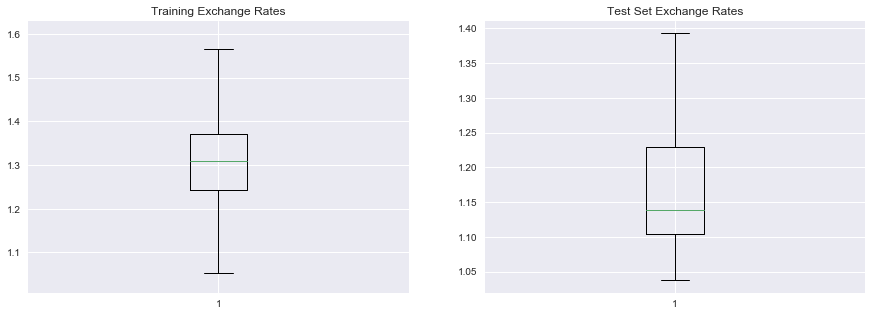

Training Data Mean: $1.31
Test Data Mean: $1.18


In [24]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(train.Rate.dropna(how = 'any'))
plt.title('Training Exchange Rates')

plt.subplot(1, 2, 2)
plt.boxplot(test.Rate.dropna(how = 'any'))
plt.title('Test Set Exchange Rates')

plt.show()

print('Training Data Mean: $%.2f' % (train.Rate.mean()))
print('Test Data Mean: $%.2f' % (test.Rate.mean()))

These individual box plots of the training and test data show greater variation in the training set - with Euro values raging from just over 1.00 to over 1.60.  The test fits within that range, from 1.05 to 1.40.  <br>
The test set shows a stronger value for the dollar, as the average Euro rate is notable lower than in the training set.

# Time Series Modeling
## ARIMA model
The primary algorithm for time series is the ARIMA model.  The model takes three parameters: <br>
AR for auto-regressive or how the data relates to it's prior values<br>
I for integrated or the level of differencing required to make the data stationary<br>
MA for moving average or how the data relates to prior errors

Since we saw stationarity in our data by taking the first difference, we will start with an integrated parameter of 1.

### AutoCorrelation Function (ACF) & Partial AutoCorrelation Function (PACF)
Comparing the exchange rate with a prior rates, testing for correlation.  Auto Correlation includes the impact of correlations between prior values, while the Partial Auto Correlation removes the impact of correlation to other prior values.  The values on the x-axis indicate the time-step shift.

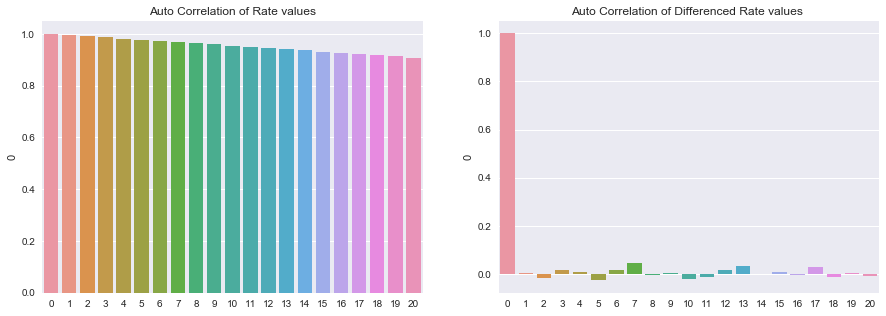

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_acf = pd.DataFrame(acf(series_train.Rate, nlags=20))
sns.barplot(x=x_acf.index, y=x_acf[0])
plt.title("Auto Correlation of Rate values")

plt.subplot(1, 2, 2)
x_acf_diff = pd.DataFrame(acf(series_train.diff_1[1:], nlags=20))
sns.barplot(x=x_acf_diff.index, y=x_acf_diff[0])
plt.title("Auto Correlation of Differenced Rate values ")
plt.show()

Differenced rate shows no correlation.

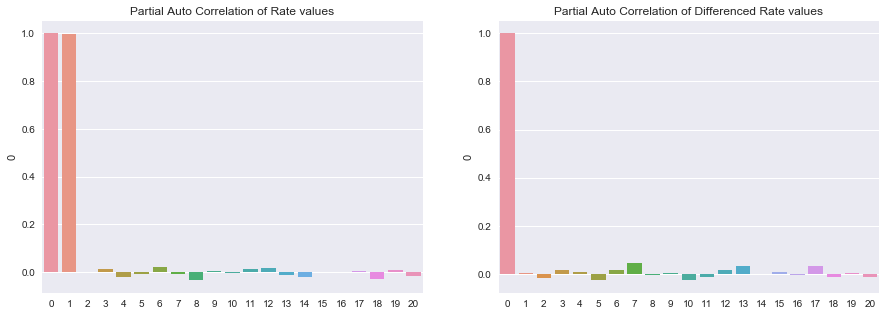

In [26]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_pacf = pd.DataFrame(pacf(series_train.Rate, nlags=20))
sns.barplot(x=x_pacf.index, y=x_pacf[0])
plt.title("Partial Auto Correlation of Rate values")

plt.subplot(1, 2, 2)
x_pacf_diff = pd.DataFrame(pacf(series_train.diff_1[1:], nlags=20))
sns.barplot(x=x_pacf_diff.index, y=x_pacf_diff[0])
plt.title("Partial Auto Correlation of Differenced Rate values")
plt.show()

The ACF of the original rates shows a gradual decline in correlations with increased time shifts.  The differenced data shows no auto correlation.<br>
The PACF of the original exchange rate values shows strong auto-correlation at 1.  The PACF of the exchange rate difference values shows no notable correlation.  <br>
We'll run some additional tests to find the best parameters for our model, but 0 for the AR and MA elements will likely be well-suited.

### Using Auto Arima to for optimal test parameters
We will use the Akaike Information Criterion (AIC) to evaluate our models.  The AIC measures how well our data is explained by the model, relative to how complex it is.

In [40]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-18441.104, BIC=-18429.261, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-18439.164, BIC=-18421.401, Fit time=0.069 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-18439.166, BIC=-18421.402, Fit time=0.048 seconds
Total fit time: 0.416 seconds
-18441.103712277098


As anticipated, an ARIMA model with 0,1,0 configuration has the lowest AIC score on our initial test.  It is worth noting that the (1, 1, 0) and (0, 1, 1) also show AIC values very close to the (0, 1, 0) model.  This means each of these models are capturing the data with similar accuracy and parsimony.

Let's test some higher order models and see how they compare.

In [41]:
train_step_model = auto_arima(train.Rate, p=7, start_q=2,
                           max_q=3, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)
print(train_step_model.aic())

Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2); AIC=-18437.215, BIC=-18395.767, Fit time=4.696 seconds
Fit ARIMA: order=(3, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 2); AIC=-18435.327, BIC=-18387.957, Fit time=3.697 seconds
Fit ARIMA: order=(4, 1, 3); AIC=-18433.663, BIC=-18380.372, Fit time=2.817 seconds
Fit ARIMA: order=(5, 1, 2); AIC=-18433.351, BIC=-18380.060, Fit time=2.627 seconds
Fit ARIMA: order=(5, 1, 3); AIC=-18431.381, BIC=-18372.169, Fit time=2.474 seconds
Total fit time: 17.064 seconds
-18437.21523242889


In [42]:
train_step_model = auto_arima(train.Rate, start_q=4, max_q=5,
                           p=7, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

Fit ARIMA: order=(2, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-18441.104, BIC=-18429.261, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-18439.164, BIC=-18421.401, Fit time=0.043 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-18439.166, BIC=-18421.402, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.598 seconds
-18441.103712277098


### Caparing MSE

In [67]:
# https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
import warnings
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.Rate, p_values, d_values, q_values)

Best ARIMANone MSE=inf


### Training the Model

In [43]:
# fit the model
model_010 = ARIMA(train.Rate, order=(0,1,0))
fit_010 = model_010.fit()
print(fit_010.summary())
print('Residuals Description')
print(fit_010.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(0, 1, 0)   Log Likelihood                9222.552
Method:                           css   S.D. of innovations              0.009
Date:                Sat, 29 Sep 2018   AIC                         -18441.104
Time:                        12:18:44   BIC                         -18429.261
Sample:                             1   HQIC                        -18436.826
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.753      0.452      -0.000       0.000
Residuals Description
count    2.755000e+03
mean     2.919964e-10
std      8.511597e-03
min     -4.242207e-02
25%     -4.522069e-03

In [44]:
# fit the model
model_011 = ARIMA(train.Rate, order=(0,1,1))
fit_011 = model_011.fit()
print(fit_011.summary())
print('Residuals Description')
print(fit_011.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(0, 1, 1)   Log Likelihood                9222.583
Method:                       css-mle   S.D. of innovations              0.009
Date:                Sat, 29 Sep 2018   AIC                         -18439.166
Time:                        12:18:44   BIC                         -18421.402
Sample:                             1   HQIC                        -18432.749
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.749      0.454      -0.000       0.000
ma.L1.D.Rate     0.0048      0.019      0.249      0.803      -0.033       0.043
                                    Roots   

In [45]:
# fit the model
model_122 = ARIMA(train.Rate, order=(1,2,2))
fit_122 = model_122.fit()
print(fit_122.summary())
print('Residuals Description')
print(fit_122.resid.describe())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D2.Rate   No. Observations:                 2754
Model:                 ARIMA(1, 2, 2)   Log Likelihood                9216.642
Method:                       css-mle   S.D. of innovations              0.009
Date:                Sat, 29 Sep 2018   AIC                         -18423.284
Time:                        12:18:49   BIC                         -18393.680
Sample:                             2   HQIC                        -18412.589
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.753e-07   2.04e-07     -0.858      0.391   -5.76e-07    2.25e-07
ar.L1.D2.Rate    -0.9850      0.013    -76.714      0.000      -1.010      -0.960
ma.L1.D2.Rate    -0.0093      0.010     

In [46]:
# fit the model
model_710 = ARIMA(train.Rate, order=(7,1,0))
fit_710 = model_710.fit()
print(fit_710.summary())
print('Residuals Description')
print(fit_710.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(7, 1, 0)   Log Likelihood                9227.503
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sat, 29 Sep 2018   AIC                         -18437.006
Time:                        12:18:50   BIC                         -18383.715
Sample:                             1   HQIC                        -18417.754
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.719      0.472      -0.000       0.000
ar.L1.D.Rate     0.0048      0.019      0.251      0.802      -0.033       0.042
ar.L2.D.Rate    -0.0133      0.019     -0.69

### Testing Model Fit

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Actual Difference with Predicted Difference with ARIMA 0,1,0 model')

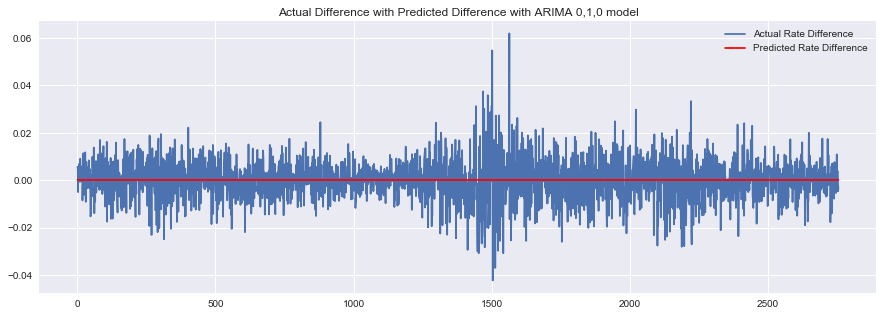

In [47]:
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

train['diff_1'] = train.Rate - train.Rate.shift()
 
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(fit_010.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Actual Difference with Predicted Difference with ARIMA 0,1,0 model')

Text(0.5,1,'Actual Difference with Predicted Difference with ARIMA 7,1,0 model')

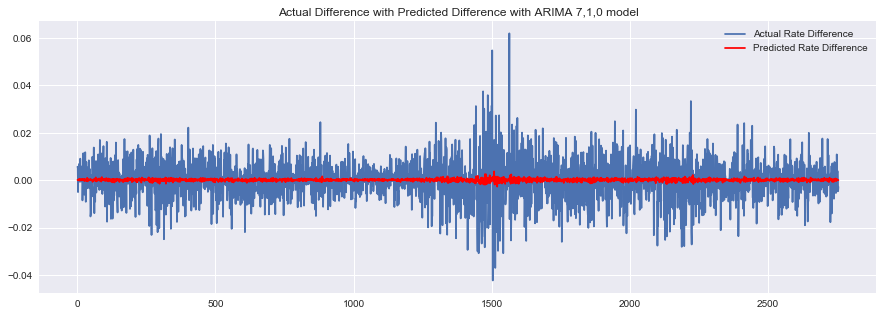

In [48]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(fit_710.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Actual Difference with Predicted Difference with ARIMA 7,1,0 model')

Text(0.5,1,'Actual Difference with Predicted Difference with ARIMA 0,1,1 model')

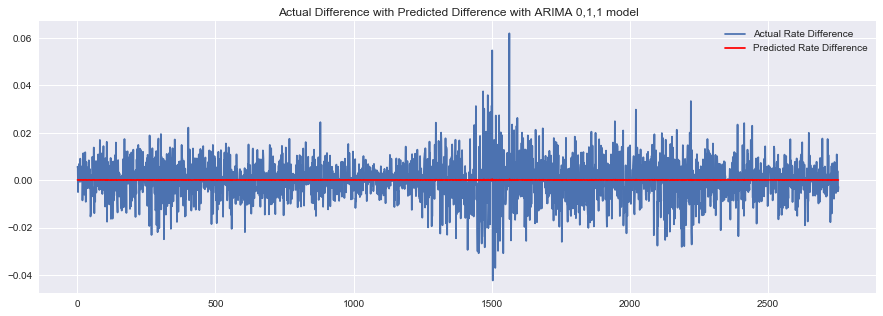

In [49]:

plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(fit_011.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Actual Difference with Predicted Difference with ARIMA 0,1,1 model')

Text(0.5,1,'Actual Difference with Predicted Difference with ARIMA 1,2,2 model')

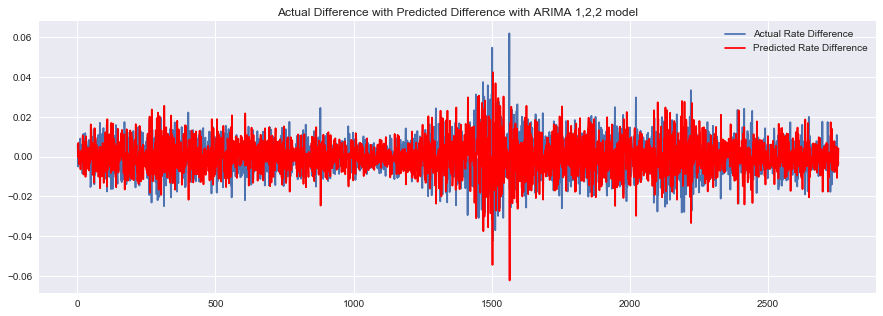

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(fit_122.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Actual Difference with Predicted Difference with ARIMA 1,2,2 model')

The (1, 2, 2) model seems to capture the variability of the data, while the other models show very little variation.

# Prediction

### Out of Sample Forecasting
Predicting values for the test range and comparing to actual values

In [51]:
# prediction (test) index range
start_index = 2756
end_index = 3937

### Predicting values with ARIMA (0, 1, 0) model.

In [52]:
# add predictions to data in new dataframe
future_forecast = fit_010.predict(start=start_index, end=end_index, dynamic=True)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict_010'])
test_predict = pd.concat([test, future_forecast], axis=1)

# calculate first predicted value
test_predict.loc[2756, ('Rate_010')] = train.loc[2755, ('Rate')] + test_predict.loc[2756, ('predict_010')]

#calculate remaining values
for i in range(start_index+1, end_index):
    old_rate = test_predict.loc[(i-1), ('Rate_010')]
    current_pred = test_predict.loc[i, ('predict_010')]
    new_rate = old_rate + current_pred
    test_predict.loc[i, ('Rate_010')] = new_rate

# creating time series of test and prediction
predict_series = test_predict.copy()
predict_series.index = pd.to_datetime(predict_series['Date'])

# describe time series data
predict_series.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800,1.139100,1.229775,1.392700
predict_010,1182.0,0.000122,0.000000,0.000122,0.000122,0.000122,0.000122,0.000122
Rate_010,1181.0,1.444543,0.041634,1.372522,1.408532,1.444543,1.480553,1.516563


In [53]:
predict_series.head()

,Date,Rate,predict_010,Rate_010
Date,,,,
2013-12-16,2013-12-16,1.3757,0.000122,1.372522
2013-12-17,2013-12-17,1.3748,0.000122,1.372644
2013-12-18,2013-12-18,1.3766,0.000122,1.372766
2013-12-19,2013-12-19,1.3666,0.000122,1.372888
2013-12-20,2013-12-20,1.3673,0.000122,1.373010


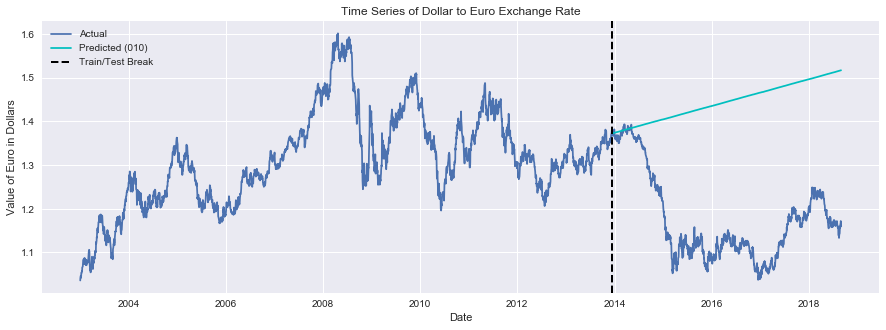

In [54]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Actual')
plt.plot(predict_series.Rate_010, label='Predicted (010)', color='c')
plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

We see the predictions of our ARIMA (0,1,0) model appear as an increasing straight line.  Let's look at the first difference of our actual data compared to the predicted difference.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


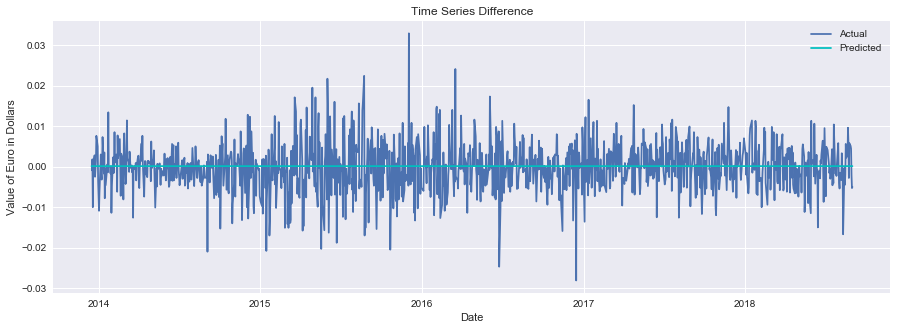

In [55]:
series_test['diff_1'] = series_test.Rate - series_test.Rate.shift()

# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(series_test.diff_1, label='Actual')
plt.plot(predict_series.predict_010, label='Predicted', color='c')
plt.title('Time Series Difference')
plt.legend()
plt.show()

Our model clearly does not capture the variation in our data.  Let's look at the residuals.

In [56]:
# calculate residuals 
predict_series['resid_010'] = predict_series.Rate - predict_series.Rate_010

In [57]:
predict_series.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800,1.139100,1.229775,1.392700
predict_010,1182.0,0.000122,0.000000,0.000122,0.000122,0.000122,0.000122,0.000122
Rate_010,1181.0,1.444543,0.041634,1.372522,1.408532,1.444543,1.480553,1.516563
resid_010,1181.0,-0.269477,0.122185,-0.426818,-0.344302,-0.313205,-0.264569,0.012976


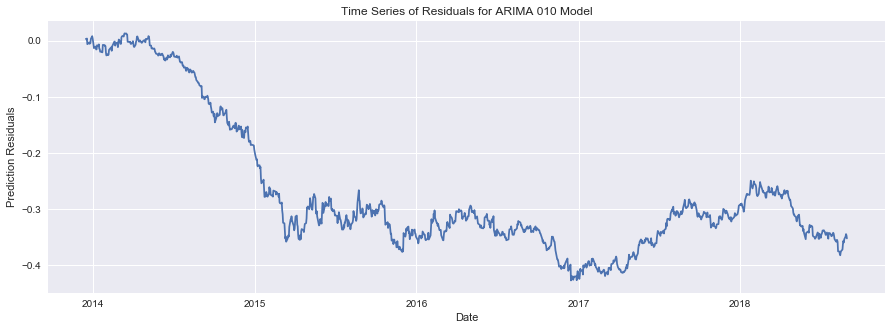

In [58]:
# plot residuals by date
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Prediction Residuals')
plt.plot(predict_series.resid_010)
plt.title('Time Series of Residuals for ARIMA 010 Model')
plt.show()

By examining the residuals of our predictions as a time series, we can clearly see that our initial predictions, into 2014, are reasonably accurate.  We can also see that this model is not able to predict the increasing value of the dollar from 2014-2015, resulting in a disparity of over 40 cents in late 2016 and early 2017.  The (0,1,0) model is not able to capture the variation in the data caused by the variety of factors that influence exchange rates.

### Predicting values with the ARIMA (1, 2, 2) model.

In [59]:
# add predictions to data in new dataframe
forecast_122 = fit_122.predict(start=start_index, end=end_index, dynamic=True)
forecast_122 = pd.DataFrame(forecast_122,index = test.index,columns=['predict_122'])
test_predict_122 = pd.concat([test, forecast_122], axis=1)
test_predict_122.head()

,Date,Rate,predict_122
2756,2013-12-16,1.3757,0.002990
2757,2013-12-17,1.3748,-0.000610
2758,2013-12-18,1.3766,0.000601
2759,2013-12-19,1.3666,-0.000592
2760,2013-12-20,1.3673,0.000583


In [60]:
# calculate first two predicted value
test_predict_122.loc[2756, ('Rate_122')] = train.loc[2755, ('Rate')] + test_predict_122.loc[2756, ('predict_122')]
test_predict_122.loc[2757, ('Rate_122')] = train.loc[2755, ('Rate')] + test_predict_122.loc[2756, ('predict_122')] + test_predict_122.loc[2757, ('predict_122')] 


#calculate remaining values
for i in range(start_index+2, end_index):
    old_rate = test_predict_122.loc[(i-2), ('Rate_122')]
    old_predict = test_predict_122.loc[(i-1), ('predict_122')]
    current_pred = test_predict_122.loc[i, ('predict_122')]
    new_rate = old_rate + old_predict + current_pred
    test_predict_122.loc[i, ('Rate_122')] = new_rate
test_predict_122.head()

,Date,Rate,predict_122,Rate_122
2756,2013-12-16,1.3757,0.002990,1.375390
2757,2013-12-17,1.3748,-0.000610,1.374779
2758,2013-12-18,1.3766,0.000601,1.375380
2759,2013-12-19,1.3666,-0.000592,1.374788
2760,2013-12-20,1.3673,0.000583,1.375371


In [61]:
test_predict_122.shape

(1182, 4)

In [62]:
predict_series_122 = test_predict_122.copy()
predict_series_122.index = pd.to_datetime(predict_series_122['Date'])
predict_series_122.head()

,Date,Rate,predict_122,Rate_122
Date,,,,
2013-12-16,2013-12-16,1.3757,0.002990,1.375390
2013-12-17,2013-12-17,1.3748,-0.000610,1.374779
2013-12-18,2013-12-18,1.3766,0.000601,1.375380
2013-12-19,2013-12-19,1.3666,-0.000592,1.374788
2013-12-20,2013-12-20,1.3673,0.000583,1.375371


In [63]:
predict_series_122.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800e+00,1.139100e+00,1.229775e+00,1.39270
predict_122,1182.0,0.000002,0.000135,-0.000610,-2.544220e-07,-1.753299e-07,-9.503000e-08,0.00299
Rate_122,1181.0,1.374979,0.000079,1.374779,1.374923e+00,1.374972e+00,1.375019e+00,1.37539


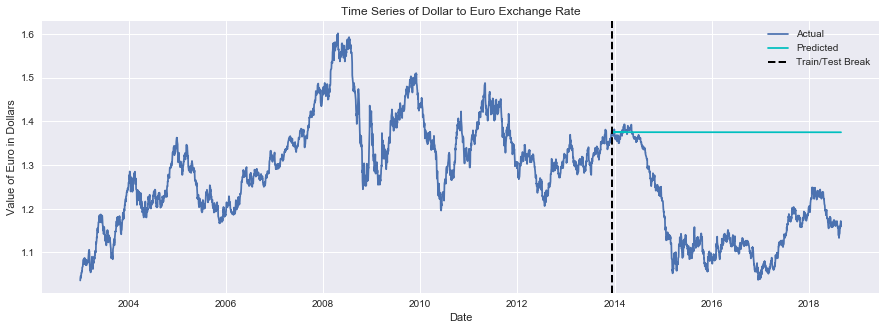

In [64]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Actual')
plt.plot(predict_series_122.Rate_122, label='Predicted', color='c')
plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

As with the (0,1,0) model, the predictions of the (1,2,2) appear as a striaght line.  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


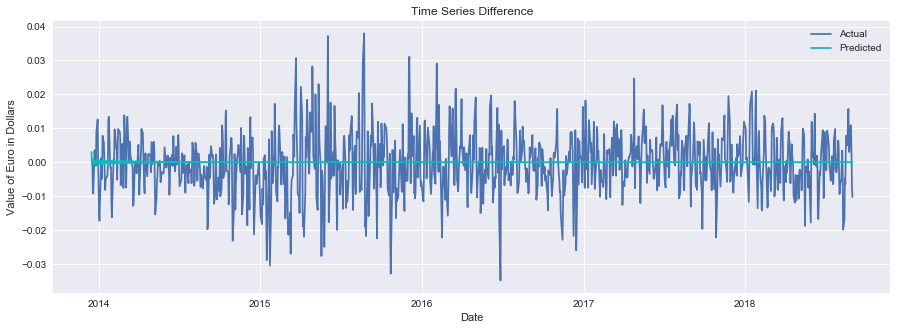

In [65]:
series_test['diff_2'] = series_test.Rate - series_test.Rate.shift(2)

# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(series_test.diff_2, label='Actual')
plt.plot(predict_series_122.predict_122, label='Predicted', color='c')
plt.title('Time Series Difference')
plt.legend()
plt.show()

In this case, while there is initially increased variation from day to day, the overall trend is to maintain the exchange rate.

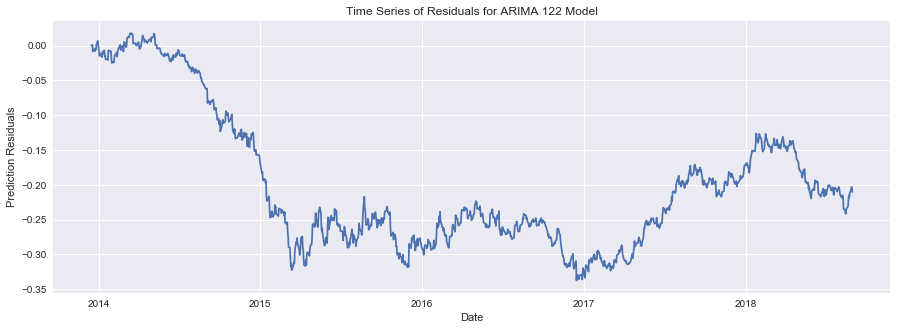

In [66]:
# calculate residuals
predict_series_122['resid'] = predict_series_122.Rate - predict_series_122.Rate_122

# plot residuals by date
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Prediction Residuals')
plt.plot(predict_series_122.resid)
plt.title('Time Series of Residuals for ARIMA 122 Model')
plt.show()

As with the (0,1,0) model the (1,2,2) model is also unable to predict the relative decrease in the value of the Euro, but because of the flat trend, the residuals are slightly better at below 35 cents.

## Alternatives to Time Series Models

# Topics for Further Exploration

There are many other paths to follow when exploring Exchange Rates.  <br>
Additional time series models are available in Facebook's Prophet. <br>